In [1]:
# Make Jupyter Notebook full screen 
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

Objective: Identify route and stop characteristics:

- Speed of route
- Ridership at stops
- Route spacing

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import datetime
import geopandas

In [3]:
print("GTFS data sets: ")
GTFS_DATA_PATH = "mmt_gtfs/"
import os; os.listdir(GTFS_DATA_PATH) # Peak whats in the directory 

GTFS data sets: 


['fare_attributes.txt',
 'transfers.txt',
 'agency.txt',
 'fare_rules.txt',
 'calendar_dates.txt',
 'stop_times.txt',
 'shapes.txt',
 'trips.txt',
 'feed_info.txt',
 'stops.txt',
 'linked_datasets.txt',
 'Metro_Transit_Ridership_by_Route_Weekday.csv',
 'stop_features.txt',
 'calendar.txt',
 'routes.txt',
 'translations.txt']

In [4]:
def getPandasDFCSV(path, file, sep=','):  
    """ Keyword Arg sep: deliminator used in txt file (default = ',')"""
    pandasDF = pd.read_csv(path +  file, sep=sep)
    return pandasDF

In [5]:
stops_df = getPandasDFCSV(GTFS_DATA_PATH, 'stops.txt')
stops_df.head()

,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,agency_id,jurisdiction_id,location_type,parent_station,relative_position,cardinal_direction,wheelchair_boarding,primary_street,address_range,cross_location
0,1110,1110,E Dayton & Wisconsin (WB),This EVENT/DETOUR ONLY stop (#1110) is westbou...,43.076428,-89.385920,MMT,CMAD,0,NaN,3,270.0,1,E Dayton,2,Wisconsin
1,1111,1111,W Doty & M L K Junior (EB),This EVENT/DETOUR ONLY stop (#1111) is eastbou...,43.072938,-89.382354,MMT,CMAD,0,NaN,3,90.0,1,W Doty,1,M L K Junior
2,1124,1124,S Fairchild & W Main (SB),This EVENT/DETOUR ONLY stop (#1124) is southbo...,43.072467,-89.385273,MMT,CMAD,0,NaN,3,180.0,1,S Fairchild,98,W Main
3,1135,1135,N Webster & E Mifflin (NB),This EVENT/DETOUR ONLY stop (#1135) is northbo...,43.077272,-89.383413,MMT,CMAD,0,NaN,1,0.0,1,N Webster,101,E Mifflin
4,1140,1140,E Washington & N Webster (WB),This EVENT/DETOUR ONLY stop (#1140) is westbou...,43.076390,-89.381930,MMT,CMAD,0,NaN,3,270.0,1,E Washington,200,N Webster


In [6]:
ridership_df = getPandasDFCSV(GTFS_DATA_PATH, 'Metro_Transit_Ridership_by_Route_Weekday.csv')
ridership_df

,X,Y,OBJECTID,StopID,Route,Lat,Lon,DailyBoardings,DotSize
0,-89.407013,43.071053,20007,5,80,43.071061,-89.407019,322.93,3229261.32
1,-89.400229,43.075889,20008,10,80,43.075897,-89.400235,875.26,8752643.70
2,-89.400229,43.075889,20009,10,81,43.075897,-89.400235,79.74,797389.24
3,-89.400229,43.075889,20010,10,82,43.075897,-89.400235,16.90,168965.00
4,-89.396990,43.075841,20011,25,81,43.075849,-89.396996,24.06,240553.18
...,...,...,...,...,...,...,...,...,...
3842,-89.318342,43.121171,23849,9984,6,43.121179,-89.318348,6.38,63833.56
3843,-89.318342,43.121171,23850,9984,20,43.121179,-89.318348,3.80,37989.96
3844,-89.301460,43.133319,23851,9993,6,43.133327,-89.301466,1.68,16798.30
3845,-89.308913,43.124842,23852,9996,20,43.124850,-89.308919,4.92,49163.47


In [7]:
stop_times_df = getPandasDFCSV(GTFS_DATA_PATH, 'stop_times.txt')
#stop_times_df.info()
#stop_times_df.head(3)

In [8]:
# Fix the times from strings and bad formatting to datetime objects:

arrivalTimesArray = np.array(stop_times_df['arrival_time'])

arrivalTimesArrayFixed = []
for time in arrivalTimesArray:
    timeList = time.split(":")
    timeList = [int(time) for time in timeList]
    if timeList[0] < 24:
        dateTime = datetime.datetime(2000, 1, 1, timeList[0], timeList[1], timeList[2])
    else:
        dateTime = datetime.datetime(2000, 1, 2, timeList[0]-24, timeList[1], timeList[2])
    arrivalTimesArrayFixed.append(dateTime)
    
stop_times_df['arrival_time'] = arrivalTimesArrayFixed

departureTimesArray = np.array(stop_times_df['departure_time'])

departureTimesArrayFixed = []
for time in departureTimesArray:
    timeList = time.split(":")
    timeList = [int(time) for time in timeList]
    if timeList[0] < 24:
        dateTime = datetime.datetime(2000, 1, 1, timeList[0], timeList[1], timeList[2])
    else:
        dateTime = datetime.datetime(2000, 1, 2, timeList[0]-24, timeList[1], timeList[2])
    departureTimesArrayFixed.append(dateTime)
    
stop_times_df['departure_time'] = departureTimesArrayFixed

#stop_times_df.head()

In [9]:
stop_times_df.head()

,trip_id,stop_sequence,stop_id,pickup_type,drop_off_type,arrival_time,departure_time,timepoint,stop_headsign,shape_dist_traveled
0,9999999,1,7605,0,1,2000-01-01 05:27:00,2000-01-01 05:27:00,1,EAST TRANSFER,0.0249
1,9999999,2,7739,0,0,2000-01-01 05:27:40,2000-01-01 05:27:40,0,EAST TRANSFER,0.2003
2,9999999,3,7119,0,0,2000-01-01 05:28:33,2000-01-01 05:28:33,0,EAST TRANSFER,0.4352
3,9999999,4,7107,0,0,2000-01-01 05:28:53,2000-01-01 05:28:53,0,EAST TRANSFER,0.5255
4,9999999,5,7663,0,0,2000-01-01 05:29:51,2000-01-01 05:29:51,0,EAST TRANSFER,0.7820


In [10]:
trips_df = getPandasDFCSV(GTFS_DATA_PATH, 'trips.txt')
#trips_df.info()
#trips_df.head(3)

In [11]:
stops_df = getPandasDFCSV(GTFS_DATA_PATH, 'stops.txt')
stops_df.info()
stops_df.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2130 entries, 0 to 2129
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   stop_id              2130 non-null   int64  
 1   stop_code            2130 non-null   object 
 2   stop_name            2130 non-null   object 
 3   stop_desc            2130 non-null   object 
 4   stop_lat             2130 non-null   float64
 5   stop_lon             2130 non-null   float64
 6   agency_id            2130 non-null   object 
 7   jurisdiction_id      2130 non-null   object 
 8   location_type        2130 non-null   int64  
 9   parent_station       5 non-null      float64
 10  relative_position    2130 non-null   int64  
 11  cardinal_direction   2122 non-null   float64
 12  wheelchair_boarding  2130 non-null   int64  
 13  primary_street       2130 non-null   object 
 14  address_range        2130 non-null   int64  
 15  cross_location       2130 non-null   o

,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,agency_id,jurisdiction_id,location_type,parent_station,relative_position,cardinal_direction,wheelchair_boarding,primary_street,address_range,cross_location
0,1110,1110,E Dayton & Wisconsin (WB),This EVENT/DETOUR ONLY stop (#1110) is westbou...,43.076428,-89.385920,MMT,CMAD,0,NaN,3,270.0,1,E Dayton,2,Wisconsin
1,1111,1111,W Doty & M L K Junior (EB),This EVENT/DETOUR ONLY stop (#1111) is eastbou...,43.072938,-89.382354,MMT,CMAD,0,NaN,3,90.0,1,W Doty,1,M L K Junior
2,1124,1124,S Fairchild & W Main (SB),This EVENT/DETOUR ONLY stop (#1124) is southbo...,43.072467,-89.385273,MMT,CMAD,0,NaN,3,180.0,1,S Fairchild,98,W Main


In [12]:
print("list of possible trips: \n")

service_id_list = []
for i in trips_df['service_id']:
    if i not in service_id_list:
        service_id_list.append(i)
print(service_id_list)

list of possible trips: 

['92_WKD', '92_SAT', '92_SUN', '92_HOL', '92_MWK', '92_WKD:R', '92_SAT:R', '92_SUN:R', '92_HOL:R', '92_SAT:L', '92_SUN:L', '92_WKD:L#6', '92_WKD:L=6', '92_WKD:S', '92_SAT:S', '92_SUN:S', '92_WKD:S#6', '92_WKD:S=6']


In [13]:
print("list of possible routes: \n")

route_short_name_list = []
for i in trips_df['route_short_name']:
    if i not in route_short_name_list:
        route_short_name_list.append(i)

route_short_name_list.sort()
print(route_short_name_list)

list of possible routes: 

[2, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18, 20, 21, 22, 23, 26, 27, 30, 31, 32, 33, 36, 39, 40, 44, 48, 49, 50, 51, 52, 55, 59, 63, 67, 68, 70, 72, 73, 75, 78, 80, 81, 82, 84]


In [14]:
trips_df_weekday_peak = trips_df[trips_df['service_id'] == '92_WKD']
trips_df_weekday_peak_R = trips_df[trips_df['service_id'] == '92_WKD:R']
trips_df_weekday_peak_s = trips_df[trips_df['service_id'] == '92_WKD:L#6']
trips_df_weekday_peak_s3 = trips_df[trips_df['service_id'] == '92_WKD:L=6']
trips_df_weekday_peak_s1 = trips_df[trips_df['service_id'] == '92_WKD:S']
trips_df_weekday_peak_s2 = trips_df[trips_df['service_id'] == '92_WKD:S#6']
trips_df_weekday_peak_s4 = trips_df[trips_df['service_id'] == '92_WKD:S=6']

dfs_wk = [trips_df_weekday_peak, trips_df_weekday_peak_R, trips_df_weekday_peak_s, 
          trips_df_weekday_peak_s1, trips_df_weekday_peak_s2, trips_df_weekday_peak_s4]

trips_df_weekday = pd.concat(dfs_wk)
trips_df_weekday.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1741 entries, 0 to 5856
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   route_id               1741 non-null   int64 
 1   route_short_name       1741 non-null   int64 
 2   service_id             1741 non-null   object
 3   trip_id                1741 non-null   int64 
 4   trip_headsign          1741 non-null   object
 5   direction_id           1741 non-null   int64 
 6   direction_name         1741 non-null   object
 7   block_id               1741 non-null   int64 
 8   shape_id               1741 non-null   int64 
 9   shape_code             1741 non-null   object
 10  trip_type              1438 non-null   object
 11  trip_sort              1741 non-null   int64 
 12  wheelchair_accessible  1741 non-null   int64 
 13  bikes_allowed          1741 non-null   int64 
dtypes: int64(9), object(5)
memory usage: 204.0+ KB


In [15]:
print("Routes for weekday trips: \n")

routes_wk_list = []
for route in trips_df_weekday['route_short_name']:
    if route not in routes_wk_list:
        routes_wk_list.append(route)

routes_wk_list.sort()
print(routes_wk_list)

Routes for weekday trips: 

[2, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18, 20, 21, 22, 23, 26, 27, 30, 31, 32, 33, 36, 39, 40, 44, 48, 49, 50, 51, 52, 55, 67, 70, 72, 73, 75, 80, 81, 82, 84]


In [16]:
# make a dictionary of routes with trip ID's for weekday service:
print("Dictionary of all the possible trips for each route during weekdays: \n\n Example output for 10 trips in route 2: \n")

tripIDList_forRoutes_weekday92 = dict()
for i in routes_wk_list:
    trip_list = []
    for j in trips_df_weekday[trips_df_weekday['route_short_name'] == i].iterrows():
        trip_list.append(j[1]['trip_id'])
    tripIDList_forRoutes_weekday92[i] = trip_list

print(tripIDList_forRoutes_weekday92[23])

Dictionary of all the possible trips for each route during weekdays: 

 Example output for 10 trips in route 2: 

[1010783, 1010782, 1010781, 1010780, 1010779, 1010778, 1010777, 1010790, 1010789, 1010788, 1010787, 1010786, 1010785, 1010784]


# Find average speed for each route: 

total distance travelled by route / time the route took

In [17]:
ridership_df[ridership_df['Route'] == 7]

totalRiders = np.sum(list(ridership_df['DailyBoardings']))

In [18]:
# Each route has a list [average speed, average stop spacing, percent of total ridership]

route_stops = dict()

totalRidersAll = np.sum(list(ridership_df['DailyBoardings']))

route_characteristics = dict()
for route in tripIDList_forRoutes_weekday92:
    route_characteristics[route] = []
    route_stops[route] = []
    
    stops_list = []
    route_trips_speeds = []
    route_trips_distances = []
    for trip in tripIDList_forRoutes_weekday92[route]:
        
        # Find speeeds: 
        stop_times_df_local = stop_times_df[stop_times_df['trip_id'] == trip]
        distance = list(stop_times_df_local['shape_dist_traveled'])[-1]
        time = list(stop_times_df_local['departure_time'])[-1] - list(stop_times_df_local['departure_time'])[0]
        speed = distance / (time.seconds / 3600)
        route_trips_speeds.append(speed)
        
        # Find average route spacing:
        spacing_list = []
        spacing = list(stop_times_df_local['shape_dist_traveled'])
        spacing.insert(0, 0.0)
        for i in range(len(spacing)-1):
            stop_spacing = spacing[i+1] - spacing[i]
            spacing_list.append(stop_spacing)
        route_trips_distances.append(np.average(spacing_list))
           
        # Add stops to dictionary:
        for stop in stop_times_df_local['stop_id']:
            if stop not in stops_list:
                stops_list.append(stop)
        
    # Get daily boardings:
    route_df = ridership_df[ridership_df['Route'] == route]
    totalRiders = np.sum(list(route_df['DailyBoardings']))
    fractionOfTotalRiders = totalRiders/totalRidersAll
    
    route_characteristics[route].append(np.average(route_trips_speeds))
    route_characteristics[route].append(np.average(route_trips_distances))
    route_characteristics[route].append(fractionOfTotalRiders)
    route_stops[route] = stops_list
    

route_characteristics

{2: [12.745161732909045, 0.18562995050404305, 0.08194163536550128],
 4: [11.436236276031133, 0.16474531587057017, 0.04083183214709426],
 5: [12.962187595064094, 0.16695103919218343, 0.023831188317039384],
 6: [13.722878069452122, 0.18382411078712713, 0.07771985681516873],
 7: [13.027457228933859, 0.1763775974025973, 0.0],
 8: [14.774251557636688, 0.18296723730633538, 0.0],
 10: [12.811899259118537, 0.19561757364723467, 0.08489136180740654],
 11: [14.099043869101633, 0.22896713906304422, 0.008304757374548366],
 12: [16.373800568181817, 0.3245167510121457, 0.005883844882480112],
 13: [15.386606357048745, 0.18861452380952384, 0.010553610232902967],
 15: [14.71786697938387, 0.2278829765349883, 0.03854061471370001],
 16: [17.53273313641246, 0.2878827777777778, 0.017963323054968963],
 17: [16.8348374394836, 0.33443492307692313, 0.00542192236691624],
 18: [19.04227542857143, 0.24865669650623548, 0.016513451217098938],
 20: [18.127673233695653, 0.24712974330357146, 0.007762750947396391],
 21: 

In [19]:
print(route_stops[2])

[6100, 2925, 2401, 2249, 2669, 2201, 2121, 2175, 2101, 2395, 2752, 2501, 2741, 2191, 2755, 2595, 2945, 2131, 2473, 2349, 2916, 2822, 2561, 2605, 2717, 2921, 133, 809, 581, 743, 455, 435, 941, 839, 883, 1324, 1101, 1787, 1495, 1227, 1831, 1397, 1121, 1151, 1209, 1767, 1157, 1577, 1329, 1533, 1717, 1923, 1715, 1561, 1877, 1759, 5100, 1325, 1267, 1707, 1177, 1379, 1504, 1922, 1254, 1122, 1156, 1968, 1692, 1116, 1892, 1798, 1250, 1636, 1834, 1996, 1662, 1138, 1404, 1966, 1100, 1310, 1558, 898, 252, 568, 670, 100, 234, 178, 160, 692, 2806, 2146, 2192, 2643, 2393, 2125, 2620, 2770, 2576, 2698, 2270, 2712, 2266, 2812, 2362, 2500, 2199, 2184, 2100, 2376, 2138, 2798, 2898, 2684, 2670, 2984, 1296, 1838, 1354, 1936]


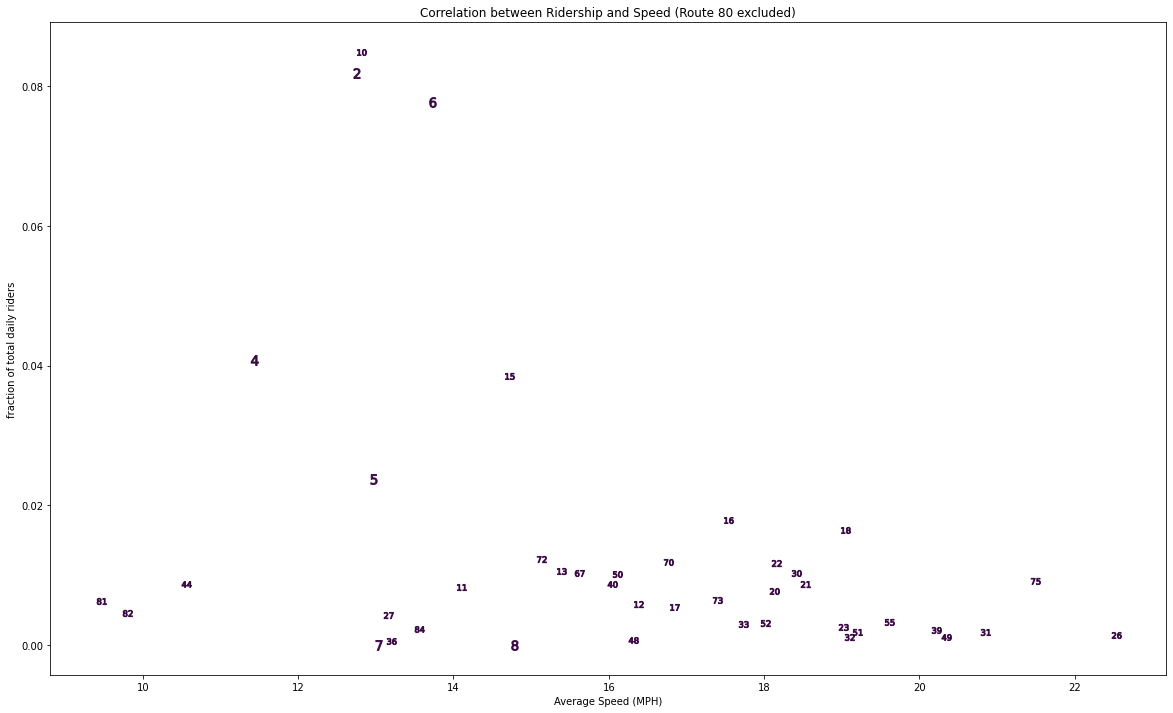

In [20]:
ax = plt.subplots(figsize=(20, 12))[1]

for i, route in enumerate(route_characteristics):
    s = route_characteristics[route]
    
    if route == 80:
        continue
    # ridership vs speed
    markerSp = "$" + str(route) + "$"
    x = s[0]
    y = s[2]
    ax.plot(x, y, color='#34013f', linewidth=3, markersize=10, marker = markerSp, alpha=.9)
    
plt.xlabel("Average Speed (MPH)")
plt.ylabel("fraction of total daily riders")
plt.title("Correlation between Ridership and Speed (Route 80 excluded)")
plt.savefig("Correlation__Ridership_Speed_no80")
plt.show()

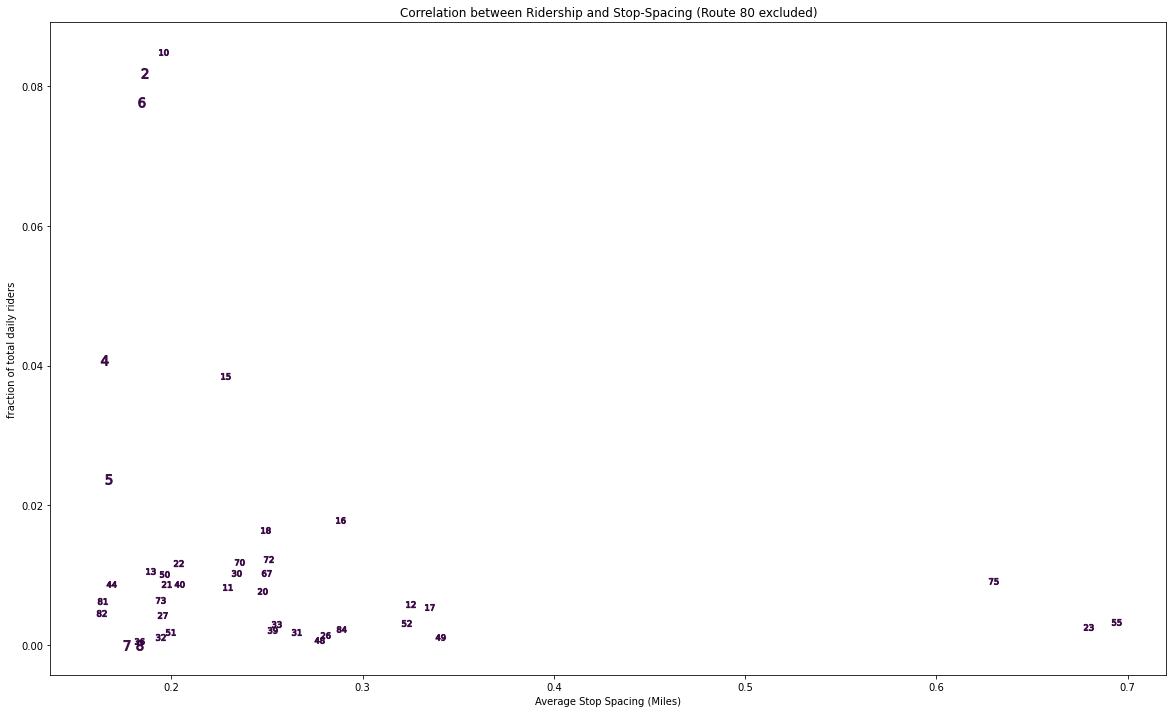

In [21]:
ax = plt.subplots(figsize=(20, 12))[1]

for i, route in enumerate(route_characteristics):
    s = route_characteristics[route]
    
    if route == 80:
        continue
    # ridership vs speed
    markerSp = "$" + str(route) + "$"
    x = s[1]
    y = s[2]
    ax.plot(x, y, color='#34013f', linewidth=3, markersize=10, marker = markerSp, alpha=.9)
    
plt.xlabel("Average Stop Spacing (Miles)")
plt.ylabel("fraction of total daily riders")
plt.title("Correlation between Ridership and Stop-Spacing (Route 80 excluded)")
plt.savefig("Correlation_Ridership_Stop-Spacing_no80")
plt.show()

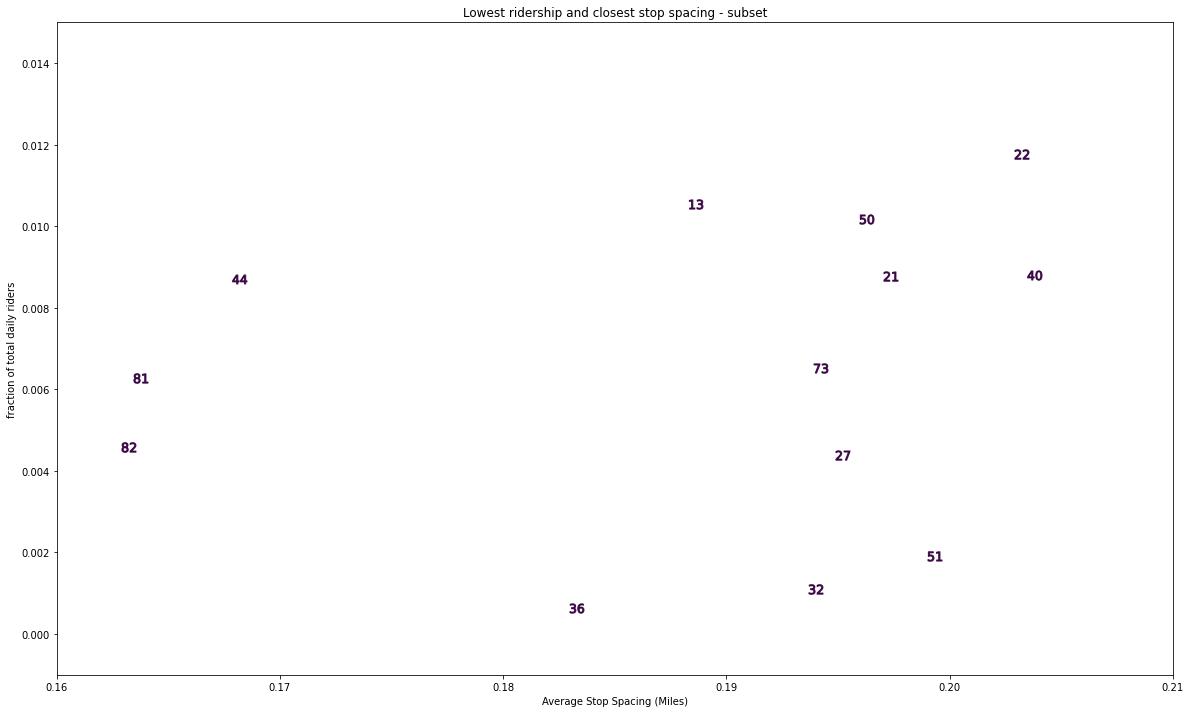

In [22]:
ax = plt.subplots(figsize=(20, 12))[1]

for i, route in enumerate(route_characteristics):
    s = route_characteristics[route]
    
    if route in (80, 7, 8):
        continue
    # ridership vs speed
    markerSp = "$" + str(route) + "$"
    x = s[1]
    y = s[2]
    ax.plot(x, y, color='#34013f', linewidth=3, markersize=15, marker = markerSp, alpha=.9)
    ax.set_xlabel("Average Stop Spacing (Miles)")
    ax.set_ylabel("")
    
plt.xlabel("Average Stop Spacing (Miles)")
plt.ylabel("fraction of total daily riders")
plt.title("Lowest ridership and closest stop spacing - subset")
plt.xlim(.16, .21)
plt.ylim(-.001, .015)
plt.savefig("Lowest_ridership_closest_stop_spacing")
plt.show()

## Investigate lowest stop spacing and lowest ridership -- seems like the best for rebalancing

* Exclude UW routes: 80, 81, 82 - different purpose

focus on: 

- 36
- 32
- 44
- 27
- 51

In [23]:
subRoutes = (27, 32, 44, 51)

subRoutes_latLon = dict()

for route in subRoutes:
    lat = []
    lon = []
    stops = route_stops[route]
    for stop in stops:
        stops_local = stops_df[stops_df['stop_id'] == stop]
        lat.append(float(stops_local['stop_lat']))
        lon.append(float(stops_local['stop_lon']))
    subRoutes_latLon[route] = [lat, lon]
    
subRoutes_latLon[27][0][:2]

[43.074636, 43.07503]

In [24]:
riderships = []
for route in route_characteristics:
    if route == 80: 
        continue
    riderships.append(route_characteristics[route][2])

ridership_avg_no_80 = np.average(riderships)
ridership_avg_no_80

0.013563229283087957

In [25]:
Speeds = []
for route in route_characteristics:
    if route == 80: 
        continue
    Speeds.append(route_characteristics[route][0])

Speeds_avg_no_80 = np.average(Speeds)
Speeds_avg_no_80

16.186439442480612

In [26]:
spacing = []
for route in route_characteristics:
    if route == 80: 
        continue
    spacing.append(route_characteristics[route][1])

Spacing_avg_no_80 = np.average(spacing)
Spacing_avg_no_80

0.2585482456435525

In [27]:
city = geopandas.read_file("shapes/City")
lakes = geopandas.read_file("shapes/Lakes")
Street = geopandas.read_file("shapes/Street")

In [28]:
colors = {27: ["#2b5d34", "#74a662"], 32:["#5f1b6b", "#895b7b"], 44:["#475f94", "#77a1b5"], 51:["#730039", "#b9484e"]}

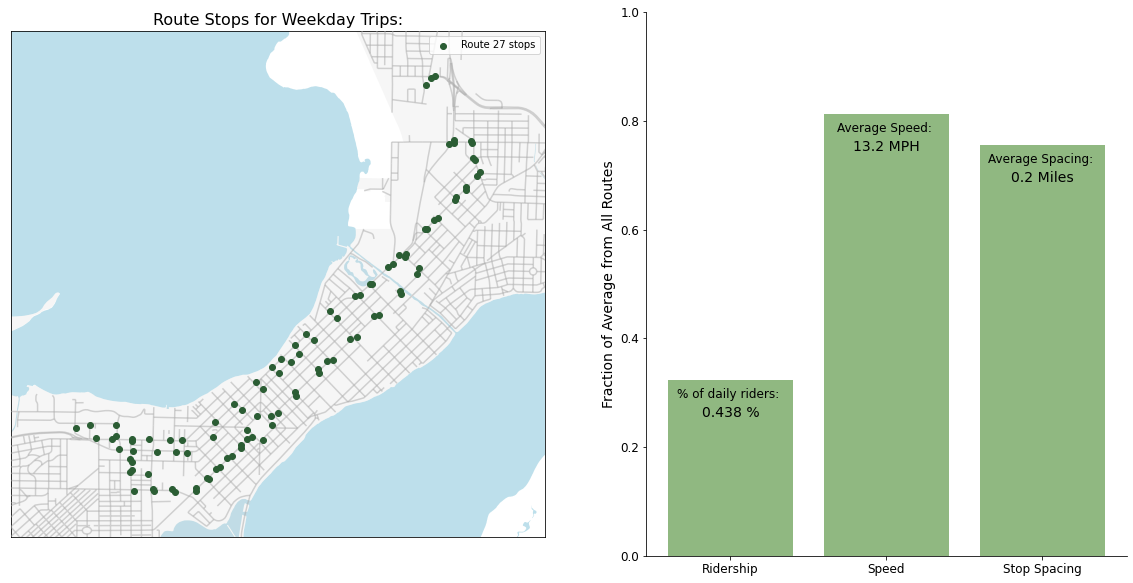

In [29]:
route = 27
ax = plt.subplots(1, 2, figsize=(20, 10), frameon=False, gridspec_kw={'width_ratios': [1, .9],'height_ratios': [2]})[1]

city.plot(color="lightgray", alpha=.2, ax=ax[0], zorder=2)
lakes.plot(color="lightblue", ax=ax[0], zorder=1, alpha=.8)
Street.plot(color="darkgray", alpha = .5, ax=ax[0], zorder=3)
   
x = subRoutes_latLon[route][1]
y = subRoutes_latLon[route][0]
ax[0].scatter(x, y, label="Route "+str(route)+" stops", color=colors[route][0], zorder=4)
       
ax[0].set_xlim(min(subRoutes_latLon[route][1])-.01, max(subRoutes_latLon[route][1])+.01)
ax[0].set_ylim(min(subRoutes_latLon[route][0])-.005, max(subRoutes_latLon[route][0])+.005)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].legend()
ax[0].set_title("Route Stops for Weekday Trips:", fontsize=16)

ridership_perc_avg = route_characteristics[route][2]/ridership_avg_no_80
speed_perc_avg = route_characteristics[route][0]/Speeds_avg_no_80
spacing_perc_avg = route_characteristics[route][1]/Spacing_avg_no_80

x_labels = ["Ridership", "Speed", "Stop Spacing"]
hist_x = (1, 2, 3)
width = .8
hist_heights = (ridership_perc_avg, speed_perc_avg, spacing_perc_avg)
ax[1].bar(x=hist_x, height=hist_heights, color=colors[route][1], tick_label=x_labels, width = width, alpha=.8)

ax[1].annotate("% of daily riders: \n", xy=(1, ridership_perc_avg-.04), ha='center', va='center', fontsize=12)
ax[1].annotate('{0:^.3f} %'.format(route_characteristics[route][2]*100), xy=(1, ridership_perc_avg-.06), ha='center', va='center', fontsize=14)

ax[1].annotate("Average Speed: \n", xy=(2, speed_perc_avg-.04), ha='center', va='center', fontsize=12)
ax[1].annotate('{0:^.1f} MPH'.format(route_characteristics[route][0]), xy=(2, speed_perc_avg-.06), ha='center', va='center', fontsize=14)

ax[1].annotate("Average Spacing: \n", xy=(3, spacing_perc_avg-.04), ha='center', va='center', fontsize=12)
ax[1].annotate('{0:^.1f} Miles'.format(route_characteristics[route][1]), xy=(3, spacing_perc_avg-.06), ha='center', va='center', fontsize=14)

ax[1].tick_params(labelsize=12)
ax[1].set_ylabel("Fraction of Average from All Routes", fontsize=14)
ax[1].set_ylim(0, max(1, speed_perc_avg+.1))
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)

plt.savefig("Route_characterstics_" + str(route))
plt.show()

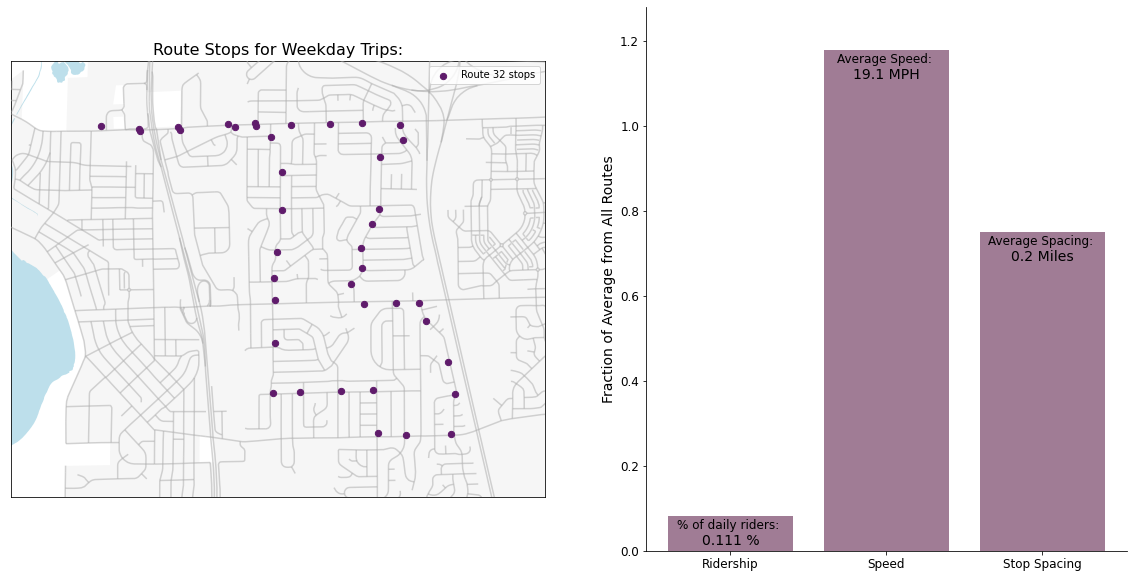

In [30]:
route = 32
ax = plt.subplots(1, 2, figsize=(20, 10), frameon=False, gridspec_kw={'width_ratios': [1, .9],'height_ratios': [2]})[1]

city.plot(color="lightgray", alpha=.2, ax=ax[0], zorder=2)
lakes.plot(color="lightblue", ax=ax[0], zorder=1, alpha=.8)
Street.plot(color="darkgray", alpha = .5, ax=ax[0], zorder=3)
   
x = subRoutes_latLon[route][1]
y = subRoutes_latLon[route][0]
ax[0].scatter(x, y, label="Route "+str(route)+" stops", color=colors[route][0], s=40, zorder=4)
       
ax[0].set_xlim(min(subRoutes_latLon[route][1])-.01, max(subRoutes_latLon[route][1])+.01)
ax[0].set_ylim(min(subRoutes_latLon[route][0])-.005, max(subRoutes_latLon[route][0])+.005)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].legend()
ax[0].set_title("Route Stops for Weekday Trips:", fontsize=16)

ridership_perc_avg = route_characteristics[route][2]/ridership_avg_no_80
speed_perc_avg = route_characteristics[route][0]/Speeds_avg_no_80
spacing_perc_avg = route_characteristics[route][1]/Spacing_avg_no_80

x_labels = ["Ridership", "Speed", "Stop Spacing"]
hist_x = (1, 2, 3)
width = .8
hist_heights = (ridership_perc_avg, speed_perc_avg, spacing_perc_avg)
ax[1].bar(x=hist_x, height=hist_heights, color=colors[route][1], tick_label=x_labels, width = width, alpha=.8)

ax[1].annotate("% of daily riders: \n", xy=(1, ridership_perc_avg-.04), ha='center', va='center', fontsize=12)
ax[1].annotate('{0:^.3f} %'.format(route_characteristics[route][2]*100), xy=(1, ridership_perc_avg-.06), ha='center', va='center', fontsize=14)

ax[1].annotate("Average Speed: \n", xy=(2, speed_perc_avg-.04), ha='center', va='center', fontsize=12)
ax[1].annotate('{0:^.1f} MPH'.format(route_characteristics[route][0]), xy=(2, speed_perc_avg-.06), ha='center', va='center', fontsize=14)

ax[1].annotate("Average Spacing: \n", xy=(3, spacing_perc_avg-.04), ha='center', va='center', fontsize=12)
ax[1].annotate('{0:^.1f} Miles'.format(route_characteristics[route][1]), xy=(3, spacing_perc_avg-.06), ha='center', va='center', fontsize=14)

ax[1].tick_params(labelsize=12)
ax[1].set_ylabel("Fraction of Average from All Routes", fontsize=14)
ax[1].set_ylim(0, max(1, speed_perc_avg+.1))
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)

plt.savefig("Route_characterstics_" + str(route))
plt.show()

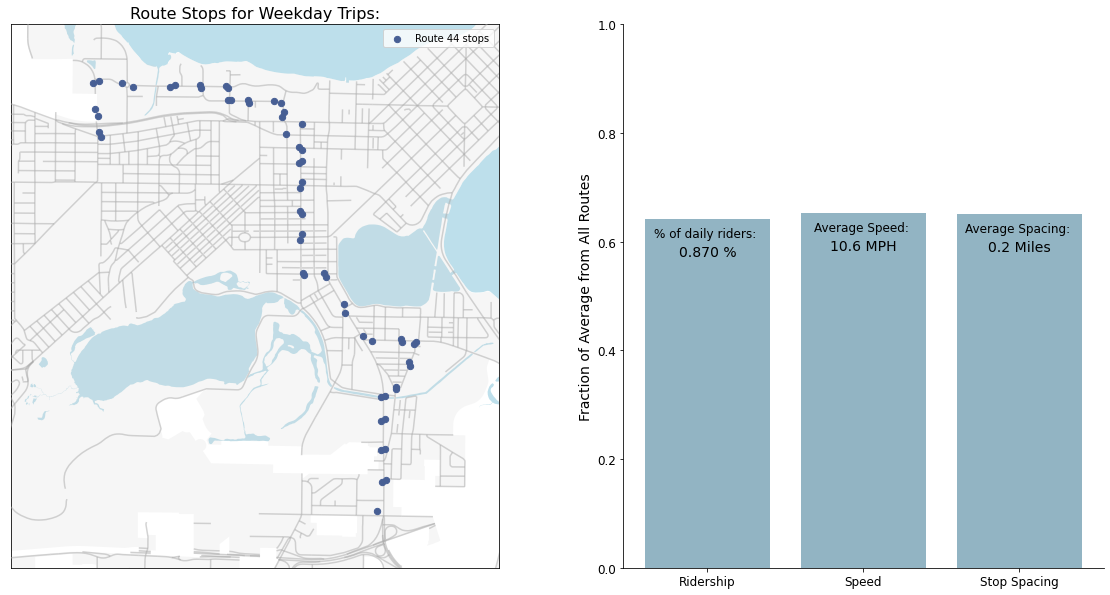

In [31]:
route = 44
ax = plt.subplots(1, 2, figsize=(20, 10), frameon=False, gridspec_kw={'width_ratios': [1, .9],'height_ratios': [2]})[1]

city.plot(color="lightgray", alpha=.2, ax=ax[0], zorder=2)
lakes.plot(color="lightblue", ax=ax[0], zorder=1, alpha=.8)
Street.plot(color="darkgray", alpha = .5, ax=ax[0], zorder=3)
   
x = subRoutes_latLon[route][1]
y = subRoutes_latLon[route][0]
ax[0].scatter(x, y, label="Route "+str(route)+" stops", color=colors[route][0], s=40, zorder=4)
       
ax[0].set_xlim(min(subRoutes_latLon[route][1])-.01, max(subRoutes_latLon[route][1])+.01)
ax[0].set_ylim(min(subRoutes_latLon[route][0])-.005, max(subRoutes_latLon[route][0])+.005)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].legend()
ax[0].set_title("Route Stops for Weekday Trips:", fontsize=16)

ridership_perc_avg = route_characteristics[route][2]/ridership_avg_no_80
speed_perc_avg = route_characteristics[route][0]/Speeds_avg_no_80
spacing_perc_avg = route_characteristics[route][1]/Spacing_avg_no_80

x_labels = ["Ridership", "Speed", "Stop Spacing"]
hist_x = (1, 2, 3)
width = .8
hist_heights = (ridership_perc_avg, speed_perc_avg, spacing_perc_avg)
ax[1].bar(x=hist_x, height=hist_heights, color=colors[route][1], tick_label=x_labels, width = width, alpha=.8)

ax[1].annotate("% of daily riders: \n", xy=(1, ridership_perc_avg-.04), ha='center', va='center', fontsize=12)
ax[1].annotate('{0:^.3f} %'.format(route_characteristics[route][2]*100), xy=(1, ridership_perc_avg-.06), ha='center', va='center', fontsize=14)

ax[1].annotate("Average Speed: \n", xy=(2, speed_perc_avg-.04), ha='center', va='center', fontsize=12)
ax[1].annotate('{0:^.1f} MPH'.format(route_characteristics[route][0]), xy=(2, speed_perc_avg-.06), ha='center', va='center', fontsize=14)

ax[1].annotate("Average Spacing: \n", xy=(3, spacing_perc_avg-.04), ha='center', va='center', fontsize=12)
ax[1].annotate('{0:^.1f} Miles'.format(route_characteristics[route][1]), xy=(3, spacing_perc_avg-.06), ha='center', va='center', fontsize=14)

ax[1].tick_params(labelsize=12)
ax[1].set_ylabel("Fraction of Average from All Routes", fontsize=14)
ax[1].set_ylim(0, max(1, speed_perc_avg+.1))
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)

plt.savefig("Route_characterstics_" + str(route))
plt.show()

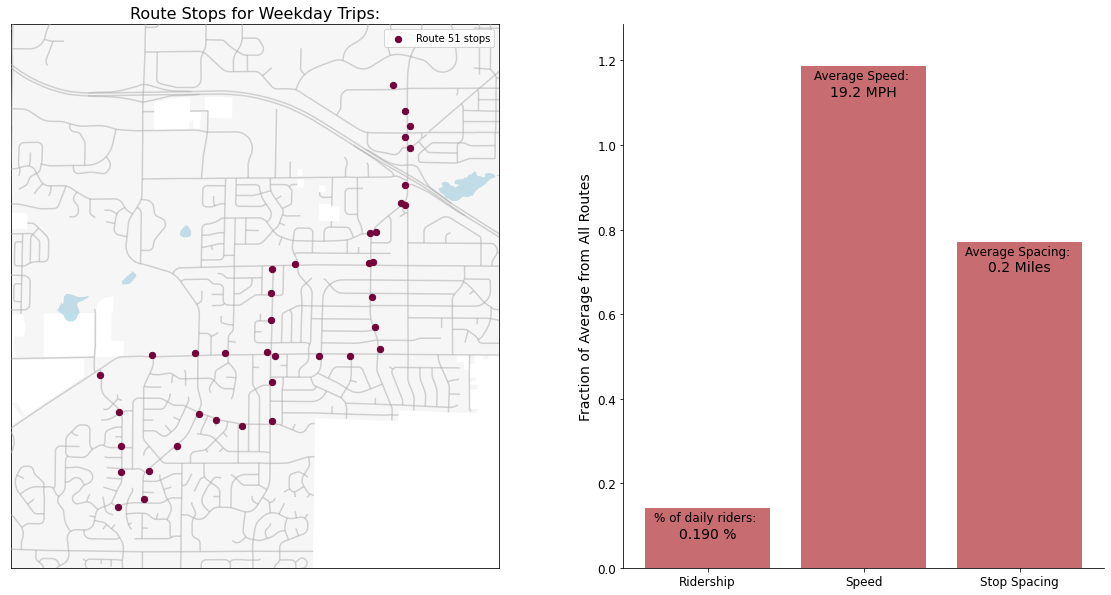

In [32]:
route = 51
ax = plt.subplots(1, 2, figsize=(20, 10), frameon=False, gridspec_kw={'width_ratios': [1, .9],'height_ratios': [2]})[1]

city.plot(color="lightgray", alpha=.2, ax=ax[0], zorder=2)
lakes.plot(color="lightblue", ax=ax[0], zorder=1, alpha=.8)
Street.plot(color="darkgray", alpha = .5, ax=ax[0], zorder=3)
   
x = subRoutes_latLon[route][1]
y = subRoutes_latLon[route][0]
ax[0].scatter(x, y, label="Route "+str(route)+" stops", color=colors[route][0], s=40, zorder=4)
       
ax[0].set_xlim(min(subRoutes_latLon[route][1])-.01, max(subRoutes_latLon[route][1])+.01)
ax[0].set_ylim(min(subRoutes_latLon[route][0])-.005, max(subRoutes_latLon[route][0])+.005)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].legend()
ax[0].set_title("Route Stops for Weekday Trips:", fontsize=16)

ridership_perc_avg = route_characteristics[route][2]/ridership_avg_no_80
speed_perc_avg = route_characteristics[route][0]/Speeds_avg_no_80
spacing_perc_avg = route_characteristics[route][1]/Spacing_avg_no_80

x_labels = ["Ridership", "Speed", "Stop Spacing"]
hist_x = (1, 2, 3)
width = .8
hist_heights = (ridership_perc_avg, speed_perc_avg, spacing_perc_avg)
ax[1].bar(x=hist_x, height=hist_heights, color=colors[route][1], tick_label=x_labels, width = width, alpha=.8)

ax[1].annotate("% of daily riders: \n", xy=(1, ridership_perc_avg-.04), ha='center', va='center', fontsize=12)
ax[1].annotate('{0:^.3f} %'.format(route_characteristics[route][2]*100), xy=(1, ridership_perc_avg-.06), ha='center', va='center', fontsize=14)

ax[1].annotate("Average Speed: \n", xy=(2, speed_perc_avg-.04), ha='center', va='center', fontsize=12)
ax[1].annotate('{0:^.1f} MPH'.format(route_characteristics[route][0]), xy=(2, speed_perc_avg-.06), ha='center', va='center', fontsize=14)

ax[1].annotate("Average Spacing: \n", xy=(3, spacing_perc_avg-.04), ha='center', va='center', fontsize=12)
ax[1].annotate('{0:^.1f} Miles'.format(route_characteristics[route][1]), xy=(3, spacing_perc_avg-.06), ha='center', va='center', fontsize=14)

ax[1].tick_params(labelsize=12)
ax[1].set_ylabel("Fraction of Average from All Routes", fontsize=14)
ax[1].set_ylim(0, max(1, speed_perc_avg+.1))
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)

plt.savefig("Route_characterstics_" + str(route))
plt.show()